In [29]:
import sys
import os
import typing as tp

import numpy as np
import scipy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

In [30]:
sys.path.append(os.path.abspath('D:\ITC\РНФ_Курганский_2024\pythonProject'))
import spin_system
import spectra_manager
import res_freq_algorithm

from importlib import reload

reload(res_freq_algorithm)
reload(spectra_manager)

<module 'spectra_manager' from 'D:\\ITC\\РНФ_Курганский_2024\\pythonProject\\spectra_manager.py'>

In [31]:
def graph(r, kappas, bessel_idxs):
    out = []
    for kappa in kappas:
        kappa_out = []
        for b_idx in bessel_idxs:
            y = (scipy.special.jv(b_idx, kappa * r)) ** 2
            kappa_out.append({"y": y, "kappa": kappa, "b_idx": b_idx})
        out.append(kappa_out)
    return out

In [32]:
r = np.linspace(0, 15, 500)
kappas = [70, 10, 1]
bessel_idxs = [0, 1, 3]

out = graph(r, kappas, bessel_idxs)

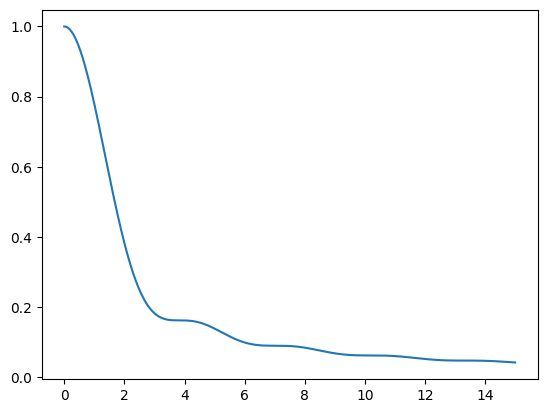

In [33]:
y = scipy.special.jv(0, r) ** 2 - scipy.special.jv(-1, r) * scipy.special.jv(1, r)
plt.plot(r, y)

figure, axes = plt.subplots(3, 1)
for axis, kappa_out in zip(axes, out):
    for bessel in kappa_out:
        kappa = bessel["kappa"]
        b_idx = bessel["b_idx"]
        y = bessel["y"]
        axis.plot(r, y, label=f"b_idx: {b_idx}")
        axis.legend()
plt.savefig("bessel_sq.eps")
plt.show()

### SpectraCreation

In [34]:
res_field = 7.0

In [35]:
freq = torch.linspace(100, 600, 1000) * 1e9  

In [36]:
interaction = spin_system.Interaction((2.01, 2.07, 2.28))
base_spin_system = spin_system.SpinSystem(electrons=[1.0], g_tensors=[interaction])
sample = spin_system.MultiOrientedSample(spin_system=base_spin_system)

creator = spectra_manager.StationarySpectraCreatorFreq(field=res_field, sample=sample, harmonic=0)

In [37]:
F, Gx, Gy, Gz = sample.get_hamiltonian_terms()

In [38]:
with torch.no_grad():
    out = creator(sample=sample, freq=freq)

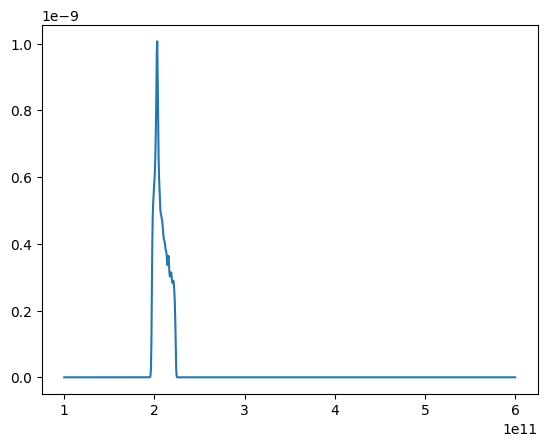

In [39]:
plt.plot(freq.numpy(), out.numpy())

In [40]:
def wigner_term_square(helicity: int, num: int, theta: torch.Tensor):
    if helicity == num:
        return torch.pow(torch.cos(theta / 2), 4)
    
    elif helicity == -num:
        return torch.pow(torch.sin(theta / 2), 4)
    
    else:
        return torch.pow(torch.sin(theta), 2) / 2

def bessel_term_kron(num: int, kappa: tp.Optional[torch.Tensor] = None, radius: tp.Optional[torch.Tensor] = None):
    return int(not bool(num))
    
def bessel_term_aver(num: int, kappa: tp.Optional[torch.Tensor] = None, radius: tp.Optional[torch.Tensor] = None):
    denom = 2 * torch.pi
    arg = kappa * radius
    numerator = scipy.special.jv(num, arg) ** 2 - scipy.special.jv(num - 1, arg) * scipy.special.jv(num + 1, arg)
    numerator = torch.from_numpy(numerator, dtype=torch.float32)
    return numerator / denom

class PlaneWaveTerms(nn.Module):
    def __init__(self, helicity: int, theta: float):
        super().__init__()
        self.theta = torch.tensor(theta)
        self.helicity = helicity
    
    def forward(self, wave_len: tp.Optional[float] = None):
        d_pl = wigner_term_square(self.helicity, 1, self.theta)
        d_zero = wigner_term_square(self.helicity, 0, self.theta)
        d_m = wigner_term_square(self.helicity, -1, self.theta)
        wigners = (d_pl, d_zero, d_m)
        return (
            self._xy_term(self.helicity, self.theta, wigners),
            self._z_term(self.helicity, self.theta, wigners),
            self._mixed_term(self.helicity, self.theta, wigners),
        )
    
    def _xy_term(self, helicity: int, theta: torch.Tensor, wigners: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        return (wigners[0] + wigners[2]) / 2
        
    def _z_term(self, helicity: int, theta: torch.Tensor, wigners: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        return wigners[1]
        
    def _mixed_term(self, helicity: int, theta: torch.Tensor, wigners: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        return wigners[0] - wigners[2]


class PlaneWaveTwBase(nn.Module):
    def __init__(self, helicity: int, theta: float, radius: float):
        super().__init__()
        self.bessel_term = self._init_bessel_term()
        self.radius = torch.tensor(radius)
        self.helicity = helicity
        self.theta = torch.tensor(theta)

    def _init_bessel_term(self):
        raise NotImplementedError
        
    def forward(self, wave_len: float):
        d_pl = wigner_term_square(helicity, 1, self.theta)
        d_zero = wigner_term_square(helicity, 0, self.theta)
        d_m = wigner_term_square(helicity, -1, self.theta)
        
        wave_len = torch.tensor(wave_len)
        kappa = torch.sin(self.theta) * wave_len
        
        J_pl = self.bessel_term(helicity + 1, kappa, self.radius)
        J_zero = self.bessel_term(helicity, kappa, self.radius)
        J_m = self.bessel_term(helicity - 1, kappa, self.radius)
        
        wigners = (d_pl, d_zero, d_m)
        bessels = (J_pl, J_zero, J_m)
        return (
            self._xy_term(self.helicity, theta, wigners, bessels),
            self._z_term(self.helicity, theta, wigners, bessels),
            self._mixed_term(self.helicity, theta, wigners, bessels),
        )
    
    def _xy_term(self, helicity: int, theta: torch.Tensor,
                 wigners: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                 bessels: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        return (wigners[0] * bessels[2] + wigners[2] * bessels[0]) / 2
        
    def _z_term(self, helicity: int, theta: torch.Tensor,
                 wigners: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                 bessels: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        return wigners[1] * bessels[1]
        
    def _mixed_term(self, helicity: int, theta: torch.Tensor,
                 wigners: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
                 bessels: tuple[torch.Tensor, torch.Tensor, torch.Tensor]):
        return wigners[0] * bessels[2] - wigners[2] * bessels[0]

In [41]:
plane = PlaneWaveTerms(-1, theta = 0.0)